**1.Import the necessary libraries**

In [ ]:
!pip install implicit
# !pip uninstall numpy -y
# !pip install "numpy<2.0"
# import os
# os.kill(os.getpid(), 9)
!pip install surprise

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import avg
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import train_test_split
import pandas as pd
import scipy.sparse as sparse
import implicit
import numpy as np
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')


**2. Create or get a Spark session**

In [ ]:
spark = SparkSession.builder \
    .appName("ALS_vs_SVD")\
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "50") \
    .getOrCreate()

**3. Load and process data**

In [ ]:
rating_df = spark.read.csv('/content/users-score-2023.csv', header=True, inferSchema=True)
rating_df = rating_df.select('user_id', 'anime_id', 'rating')

In [ ]:
from pyspark.sql.functions import isnan, col

# Count the number of records that do not have NaN values ​​in the 'rating' column
count_nan_df = rating_df.na.drop().filter(~isnan(col('rating'))).count()

print(f"Total entries: {rating_df.count()}")
print(f"Eligible entries: {count_nan_df}")
print(f"Ratio of eligible entries: {count_nan_df/rating_df.count()*100}%")

Total entries: 10688032
Eligible entries: 10688032
Ratio of eligible entries: 100.0%


In [ ]:
from pyspark.sql.functions import avg
rating_df = rating_df.groupBy("user_id", "anime_id").agg(avg("rating").alias("rating"))
rating_df.persist()

DataFrame[user_id: int, anime_id: int, rating: double]

In [ ]:
rating_sampled_df = rating_df

In [ ]:
train_df, test_df = rating_sampled_df.randomSplit([0.75, 0.25], seed=42)
# Loại bỏ các dòng có giá trị NaN hoặc null trong cột 'rating'
train_df = train_df.na.drop(subset=["rating"])
test_df = test_df.na.drop(subset=["rating"])

# Kiểm tra lại số dòng sau khi làm sạch
print(f"Cleaned train_df count: {train_df.count()}")
print(f"Cleaned test_df count: {test_df.count()}")

Cleaned train_df count: 8014321
Cleaned test_df count: 2672423


**4. Training the ALS model**

In [ ]:
# Cell 5:
als = ALS(
    userCol="user_id",
    itemCol="anime_id",
    ratingCol="rating",
    nonnegative=True,
    implicitPrefs=False,
    coldStartStrategy="drop",
    maxIter=10,
    rank=50,
    regParam=0.1
)

als_model = als.fit(train_df)

# Dự đoán trên tập validation
test_predictions = als_model.transform(test_df)

# Tính RMSE trên validation
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
test_rmse_als = evaluator.evaluate(test_predictions)

print(f"ALS Validation RMSE = {test_rmse_als:.4f}")


ALS Validation RMSE = 1.2383


**5. Prepare Data for Surprise**

In [ ]:
# Define a Reader to specify the format of your data.
# Assume ratings are in the range 1-10 (adjust if needed).
reader = Reader(rating_scale=(1, 10))
train_pd = train_df.toPandas()
test_pd = test_df.toPandas()
# Load the data from the Pandas DataFrames.  Surprise needs specific column names.
train_surprise = Dataset.load_from_df(train_pd[['user_id', 'anime_id', 'rating']], reader)
test_surprise = Dataset.load_from_df(test_pd[['user_id', 'anime_id', 'rating']], reader)


**6. Train SVD Model**

In [ ]:
# Initialize the SVD model.  You can tune parameters like n_factors (number of factors).
svd = SVD(n_factors=50, random_state=42)  # Using the same number of factors as ALS for comparison

# Train the SVD model on the training set.
trainset = train_surprise.build_full_trainset()
svd.fit(trainset)

**7. Evaluate SVD**

In [ ]:
# Make predictions on the test set.
testset = list(test_surprise.build_full_trainset().build_testset())
predictions = svd.test(testset)

# Calculate RMSE.
rmse_svd = accuracy.rmse(predictions)

print(f"SVD Test RMSE: {rmse_svd:.4f}")

RMSE: 1.2424
SVD Test RMSE: 1.2424


**8. Comparison RMSE between ALS and SVD**

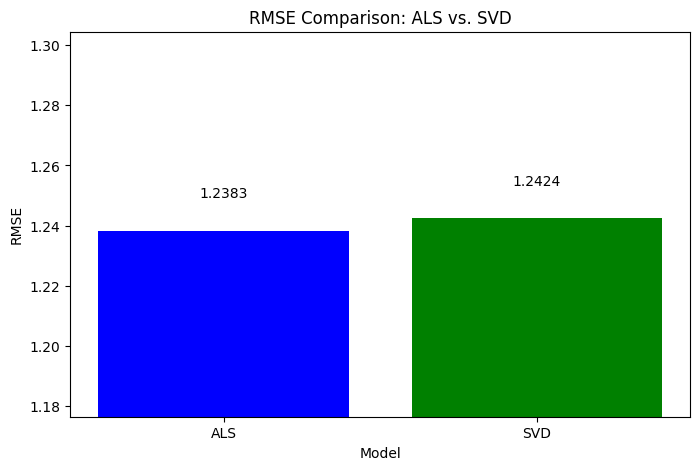

ALS performs better than SVD on RMSE


In [ ]:
import matplotlib.pyplot as plt

models = ['ALS', 'SVD']
rmse_values = [test_rmse_als, rmse_svd]

# Create the bar chart
plt.figure(figsize=(8, 5))
plt.bar(models, rmse_values, color=['blue', 'green'])
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.title("RMSE Comparison: ALS vs. SVD")
plt.ylim(min(rmse_values) * 0.95, max(rmse_values) * 1.05)

# Add the values on top of the bars
for i, value in enumerate(rmse_values):
    plt.text(i, value + 0.01, f"{value:.4f}", ha='center', va='bottom')

plt.show()

# Optional: Textual comparison
if test_rmse_als < rmse_svd:
    print("ALS performs better than SVD on RMSE")
elif rmse_svd < test_rmse_als:
    print("SVD performs better than ALS on RMSE")
else:
    print("ALS and SVD perform equally well on RMSE")